In [1]:
%%capture
!pip install transformers

In [2]:
import numpy as np
import pandas as pd



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import torch
import transformers


import warnings
import time
warnings.filterwarnings('ignore')



### Setting Global Options 

In [3]:
sst2_path = '../../data/SST-2'

pre_trained_weights_type = 'distilbert-base-uncased'

In [4]:
# Read SST-2 Training Data 

sst2_train = pd.read_csv(sst2_path + '/train.tsv', delimiter='\t')

In [5]:
sst2_train.shape

(67349, 2)

In [6]:
sst2_train.head(10)

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
5,that 's far too tragic to merit such superfici...,0
6,demonstrates that the director of such hollywo...,1
7,of saucy,1
8,a depressed fifteen-year-old 's suicidal poetry,0
9,are more deeply thought through than in most `...,1


In [7]:
# Balance of Binary Classification Data 
sst2_train['label'].value_counts()

1    37569
0    29780
Name: label, dtype: int64

### Import Model Class , tokenizer Class and Pretrained Weights for Fine Tuning 

In [8]:
from transformers import DistilBertModel , DistilBertTokenizer

In [9]:
# Setting pre_trained weights 

pre_trained_weights = pre_trained_weights_type 

# Call the Model 
distilbert_model = DistilBertModel.from_pretrained(pre_trained_weights)

# Call the Tokenizer 

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(pre_trained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Testing Tokenizer 


inputs_dict  = distilbert_tokenizer("Hello, This is advanced deep learning project  dog is cute")

inputs = distilbert_tokenizer("Hello, This is advanced deep learning project  dog is cute",return_tensors="pt")


In [11]:
# Testing Tokenizer Decoder 

distilbert_tokenizer.decode(inputs_dict['input_ids'])


# [CLS] and [SEP] token automatically by the tokenizer.

'[CLS] hello, this is advanced deep learning project dog is cute [SEP]'

In [12]:
# Testing  Model output 

output = distilbert_model(**inputs)

output

BaseModelOutput(last_hidden_state=tensor([[[-0.2510, -0.2709, -0.1863,  ..., -0.1781,  0.5094,  0.4488],
         [-0.0467, -0.0613,  0.1825,  ..., -0.1007,  0.6694,  0.1631],
         [-0.6046,  0.3725,  0.0982,  ..., -0.6424,  0.3384,  0.3223],
         ...,
         [-0.4128, -0.1646, -0.0258,  ..., -0.2339,  0.3324,  0.6773],
         [-0.6143, -0.2866, -0.0437,  ...,  0.0671,  0.2521, -0.0413],
         [ 0.8033,  0.1470, -0.5313,  ...,  0.0929, -0.3844, -0.2817]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

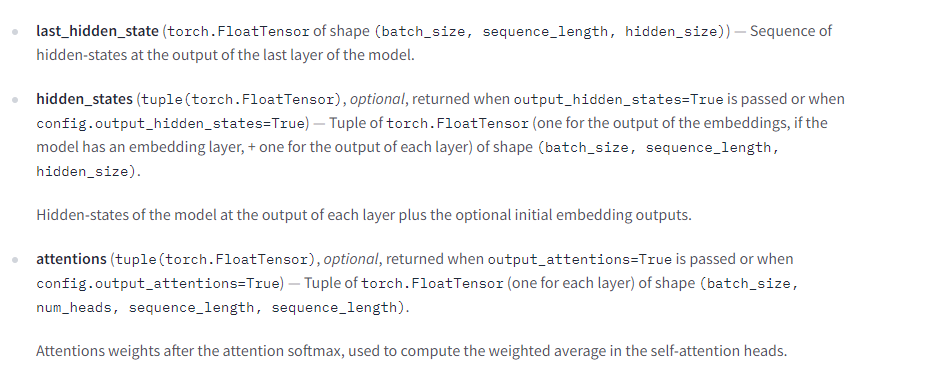

In [13]:
output.last_hidden_state 

tensor([[[-0.2510, -0.2709, -0.1863,  ..., -0.1781,  0.5094,  0.4488],
         [-0.0467, -0.0613,  0.1825,  ..., -0.1007,  0.6694,  0.1631],
         [-0.6046,  0.3725,  0.0982,  ..., -0.6424,  0.3384,  0.3223],
         ...,
         [-0.4128, -0.1646, -0.0258,  ..., -0.2339,  0.3324,  0.6773],
         [-0.6143, -0.2866, -0.0437,  ...,  0.0671,  0.2521, -0.0413],
         [ 0.8033,  0.1470, -0.5313,  ...,  0.0929, -0.3844, -0.2817]]],
       grad_fn=<NativeLayerNormBackward0>)

### Let us prepare the dataset

In [14]:
# Apply tokenizer of all the Reviews 
sst2_train = sst2_train[:10000]


sst2_train_tokenized = sst2_train['sentence'].apply(lambda x : distilbert_tokenizer.encode(x, add_special_tokens=True))

In [15]:
sst2_train_tokenized.shape

(10000,)

In [16]:
sst2_train_max_tokensize = np.max(sst2_train_tokenized.apply(lambda x : len(x)))

In [17]:
sst2_train_max_tokensize

63

In [18]:
sst2_train_tokenized_padded = np.array([i + [0]*(sst2_train_max_tokensize-len(i)) for i in sst2_train_tokenized.values])

In [19]:
sst2_train_tokenized_padded.shape

(10000, 63)

In [20]:
attention_mask = np.where(sst2_train_tokenized_padded != 0, 1, 0)
attention_mask.shape

(10000, 63)

In [21]:
sst2_train_model_inputs  = torch.tensor(sst2_train_tokenized_padded)  

sst2_train_model_attentionmask = torch.tensor(attention_mask)

with torch.no_grad():
        last_hidden_states = distilbert_model(sst2_train_model_inputs, 
                                                  attention_mask=sst2_train_model_attentionmask)
    

In [22]:
last_hidden_states[0].shape

torch.Size([10000, 63, 768])

In [23]:
features = last_hidden_states[0][:,0,:].numpy()

In [24]:
labels = sst2_train['label']

In [25]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)


In [26]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [27]:
lr_clf.score(test_features, test_labels)


0.8576